In [1]:
import pandas as pd 
import numpy as np
import re
import plotly.express as px
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

List of New features:
1. Is Mixed: Checks if mixed breed
2. Breed
3. Color
5. Intake Type
6. Intake Condition
7. Animal Type
8. Age upon Intake
9. Outcome Time
10. Intake Time
11. Length of Stay: Time spent in shelter
12. Age Group: split age

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.dtypes

Id                  object
Name                object
Intake Time         object
Found Location      object
Intake Type         object
Intake Condition    object
Animal Type         object
Sex upon Intake     object
Age upon Intake     object
Breed               object
Color               object
Outcome Time        object
Date of Birth       object
Outcome Type        object
dtype: object

In [4]:
#Drop Duplicates
df.drop_duplicates(inplace=True)

In [5]:
#datetime attributes
df['Intake Time'] = pd.to_datetime(df['Intake Time'])
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'])

In [6]:
#age conversion to number
def parse_age(age_str):
    # Example: Convert "2 years" or "8 months" to a float value in years
    if pd.isnull(age_str):
        return None
    age_str = age_str.lower()
    num = float(re.findall(r'\d+\.?\d*', age_str)[0])
    if "year" in age_str:
        return num
    elif "month" in age_str:
        return num / 12
    elif "week" in age_str:
        return num / 52
    elif "day" in age_str:
        return num / 365
    return None

df['Age upon Intake (years)'] = df['Age upon Intake'].apply(parse_age)

In [7]:
df.isnull().sum()

Id                             0
Name                       31383
Intake Time                    0
Found Location                 0
Intake Type                    0
Intake Condition               0
Animal Type                    0
Sex upon Intake                2
Age upon Intake                1
Breed                          0
Color                          0
Outcome Time                   0
Date of Birth                  0
Outcome Type                   0
Age upon Intake (years)        1
dtype: int64

In [8]:
#Drop Empty Records. Maybe Impute? We will see!
df = df.dropna(subset=["Sex upon Intake", "Age upon Intake"])

In [9]:
#drop found location. 
df = df.drop("Found Location", axis=1)

In [10]:
df = df.drop("Date of Birth", axis=1)

In [11]:
#drop name, since it is not in test features
df = df.drop("Name", axis=1)

In [12]:
#drop outcome time since it is not in test features
df = df.drop("Outcome Time", axis=1)

In [13]:
#Drop Intake Time, since it is useless(I think)
df = df.drop("Intake Time", axis=1)

In [14]:
#drop age, since we have converted it already(check to make sure)
df = df.drop("Age upon Intake", axis=1)

In [15]:
#convert objects to strings
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

In [16]:
df.dtypes

Id                         string[python]
Intake Type                string[python]
Intake Condition           string[python]
Animal Type                string[python]
Sex upon Intake            string[python]
Breed                      string[python]
Color                      string[python]
Outcome Type               string[python]
Age upon Intake (years)           float64
dtype: object

In [17]:
#Get categorical columns
string_col=df.select_dtypes("string").columns.to_list()

In [18]:
#Number of columns 
num_col=df.columns.to_list()
print(num_col)
for col in string_col:
    num_col.remove(col)

print(num_col)

['Id', 'Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Breed', 'Color', 'Outcome Type', 'Age upon Intake (years)']
['Age upon Intake (years)']


In [19]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age upon Intake (years),111155.0,1.906166,2.865777,0.0,0.083333,1.0,2.0,24.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111155 entries, 0 to 111156
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       111155 non-null  string 
 1   Intake Type              111155 non-null  string 
 2   Intake Condition         111155 non-null  string 
 3   Animal Type              111155 non-null  string 
 4   Sex upon Intake          111155 non-null  string 
 5   Breed                    111155 non-null  string 
 6   Color                    111155 non-null  string 
 7   Outcome Type             111155 non-null  string 
 8   Age upon Intake (years)  111155 non-null  float64
dtypes: float64(1), string(8)
memory usage: 8.5 MB


In [21]:
#scale age data
scaler = StandardScaler()
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [22]:
#one hot encode gender
df[string_col].head()
for col in string_col:
    print(f"The distribution of categorical valeus in the {col} is : ")
    print(df[col].value_counts())

The distribution of categorical valeus in the Id is : 
Id
A706918    1
A783861    1
A635072    1
A844350    1
A708452    1
          ..
A912501    1
A904754    1
A909378    1
A912293    1
A912037    1
Name: count, Length: 111155, dtype: Int64
The distribution of categorical valeus in the Intake Type is : 
Intake Type
Stray                 82162
Owner Surrender       21446
Public Assist          6131
Abandoned              1233
Euthanasia Request      182
Wildlife                  1
Name: count, dtype: Int64
The distribution of categorical valeus in the Intake Condition is : 
Intake Condition
Normal        95008
Injured        6394
Sick           4295
Nursing        2957
Neonatal       1240
Aged            373
Medical         298
Other           247
Pregnant        111
Feral           104
Med Attn         48
Behavior         42
Unknown          12
Neurologic       10
Med Urgent        7
Parvo             5
Space             2
Agonal            1
Congenital        1
Name: count, dtype: I

In [23]:
#Intake type, merge euthanasia and Wildlife
df['Intake Type'] = df['Intake Type'].replace({
    'Euthanasia Request': 'Other',
    'Wildlife': 'Other'
})

In [24]:
#Intake condition group rare conditions
infrequent_conditions = [
    "Aged", "Medical", "Other", "Pregnant", "Panleuk","Feral", "Med Attn", 
    "Behavior", "Unknown", "Neurologic", "Med Urgent", "Parvo", 
    "Space", "Agonal", "Congenital"
]
df['Intake Condition'] = df['Intake Condition'].replace(infrequent_conditions, 'Other')
print(df['Intake Condition'].value_counts())

Intake Condition
Normal      95008
Injured      6394
Sick         4295
Nursing      2957
Other        1261
Neonatal     1240
Name: count, dtype: Int64


In [25]:
df['Sex upon Intake'] = df['Sex upon Intake'].astype(object)

# Replace "Unknown" with np.nan, and ensure pd.NA are converted to np.nan
df['Sex upon Intake'] = df['Sex upon Intake'].replace("Unknown", np.nan)
df['Sex upon Intake'] = df['Sex upon Intake'].replace({pd.NA: np.nan})

# Create the imputer instance
imputer = SimpleImputer(strategy="most_frequent")

# Fit-transform and flatten the result to 1D
df['Sex upon Intake'] = imputer.fit_transform(df[['Sex upon Intake']]).ravel()

In [26]:
breed_counts = df['Breed'].value_counts()
print(breed_counts)

Breed
Domestic Shorthair Mix                    25361
Domestic Shorthair                        16046
Pit Bull Mix                               6042
Labrador Retriever Mix                     5654
Chihuahua Shorthair Mix                    4896
                                          ...  
Anatol Shepherd/Belgian Malinois              1
Lhasa Apso/Standard Poodle                    1
Chihuahua Shorthair/Dachshund Longhair        1
Dachshund Longhair/Yorkshire Terrier          1
Labrador Retriever/Akbash                     1
Name: count, Length: 2440, dtype: Int64


In [27]:
#Grouping Breeds Together simple
df['Breed'] = df['Breed'].str.strip()
df['Breed'] = df['Breed'].fillna('Unknown')
breed_counts = df['Breed'].value_counts()
threshold = 200
rare_breeds = breed_counts[breed_counts < threshold].index
df['Breed_Grouped'] = df['Breed'].apply(lambda x: 'Other' if x in rare_breeds else x)

In [28]:
color_counts = df['Color'].value_counts()
print(color_counts)

Color
Black/White                11620
Black                       9674
Brown Tabby                 7708
White                       3945
Brown Tabby/White           3862
                           ...  
Brown/Orange                   1
Calico/Blue Tabby              1
Silver Lynx Point/White        1
Tortie/Blue Merle              1
Brown Tabby/Gold               1
Name: count, Length: 568, dtype: Int64


In [29]:
def improved_color_grouping(color):
    """
    Group a detailed color description into a broader category based on training dataset insights.
    
    Parameters:
        color (str): The original color value.
        
    Returns:
        str: A grouped color category.
    """
    # Handle missing values
    if pd.isnull(color):
        return "Unknown"
    
    # Normalize the color string
    c = color.lower().strip()

    # Check for composite color indications
    if "/" in c:
        return "Mixed"
    
    # Define a list of base colors that are common in the dataset
    base_colors = ["black", "white", "brown", "tan", "gray", "grey", "cream", "apricot", "sable"]
    
    
    found_colors = [base for base in base_colors if base in c]
    
    
    if "tabby" in c:
        
        if found_colors:
            return f"{found_colors[0].capitalize()} Tabby"
        else:
            return "Tabby"
    
    
    if len(found_colors) == 1:
        return found_colors[0].capitalize()
    
    
    if len(found_colors) > 1:
        return "Mixed"
    
    # Fallback for any colors that do not match our list of known base colors
    return "Other"

# Example usage:
df['Color_Grouped'] = df['Color'].apply(improved_color_grouping)
print(df['Color_Grouped'].value_counts())

Color_Grouped
Mixed          58083
Other          16019
Black           9981
Brown Tabby     7708
Tabby           5794
White           3945
Brown           3723
Tan             2740
Cream Tabby      970
Cream            757
Sable            443
Gray Tabby       358
Gray             352
Black Tabby      215
Apricot           67
Name: count, dtype: int64


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111155 entries, 0 to 111156
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       111155 non-null  string 
 1   Intake Type              111155 non-null  string 
 2   Intake Condition         111155 non-null  string 
 3   Animal Type              111155 non-null  string 
 4   Sex upon Intake          111155 non-null  object 
 5   Breed                    111155 non-null  string 
 6   Color                    111155 non-null  string 
 7   Outcome Type             111155 non-null  string 
 8   Age upon Intake (years)  111155 non-null  float64
 9   Breed_Grouped            111155 non-null  object 
 10  Color_Grouped            111155 non-null  object 
dtypes: float64(1), object(3), string(7)
memory usage: 10.2+ MB


In [31]:
#Drop Color and Breed
df = df.drop("Color", axis=1)
df = df.drop("Breed", axis=1)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111155 entries, 0 to 111156
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       111155 non-null  string 
 1   Intake Type              111155 non-null  string 
 2   Intake Condition         111155 non-null  string 
 3   Animal Type              111155 non-null  string 
 4   Sex upon Intake          111155 non-null  object 
 5   Outcome Type             111155 non-null  string 
 6   Age upon Intake (years)  111155 non-null  float64
 7   Breed_Grouped            111155 non-null  object 
 8   Color_Grouped            111155 non-null  object 
dtypes: float64(1), object(3), string(5)
memory usage: 8.5+ MB


In [33]:
# One-hot encoding categorical features
categorical_features = ['Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Breed_Grouped', 'Color_Grouped']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=False)

In [34]:
# print(df_encoded.dtypes)
non_numeric_cols = df_encoded.select_dtypes(exclude=[np.number]).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: ['Id', 'Outcome Type', 'Intake Type_Abandoned', 'Intake Type_Other', 'Intake Type_Owner Surrender', 'Intake Type_Public Assist', 'Intake Type_Stray', 'Intake Condition_Injured', 'Intake Condition_Neonatal', 'Intake Condition_Normal', 'Intake Condition_Nursing', 'Intake Condition_Other', 'Intake Condition_Sick', 'Animal Type_Cat', 'Animal Type_Dog', 'Sex upon Intake_Intact Female', 'Sex upon Intake_Intact Male', 'Sex upon Intake_Neutered Male', 'Sex upon Intake_Spayed Female', 'Breed_Grouped_American Bulldog Mix', 'Breed_Grouped_American Pit Bull Terrier Mix', 'Breed_Grouped_Anatol Shepherd Mix', 'Breed_Grouped_Australian Cattle Dog', 'Breed_Grouped_Australian Cattle Dog Mix', 'Breed_Grouped_Australian Kelpie Mix', 'Breed_Grouped_Australian Shepherd Mix', 'Breed_Grouped_Beagle Mix', 'Breed_Grouped_Black Mouth Cur Mix', 'Breed_Grouped_Border Collie Mix', 'Breed_Grouped_Boxer', 'Breed_Grouped_Boxer Mix', 'Breed_Grouped_Cairn Terrier Mix', 'Breed_Grouped_Catahoula Mix'

In [35]:
#Separate target from non-target
X_original=df_encoded.drop(columns=[ "Id", "Outcome Type"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_original)

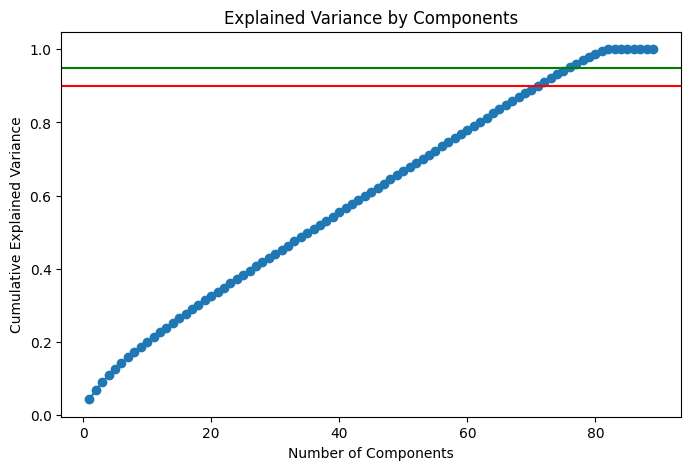

In [36]:
#Find how much dimensionality to reduce via PCA(Not actually used though, since it is not necessary!)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA without reducing dimensions to get the full variance decomposition
pca_full = PCA()
pca_full.fit(scaled_features)

# Calculate the cumulative explained variance
cumulative_variance = pca_full.explained_variance_ratio_.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.axhline(y=0.95, color='g', linestyle='-')
plt.show()
#Note PCA not used since I observed significant gains in balanced accuracy when not using it

In [37]:
#Chosen PCA based on prev plot
n_components = 70
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(scaled_features)

# Create a new DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components,
                            columns=[f'PC{i+1}' for i in range(n_components)])

print(principal_df.head())
print("Explained variance ratio per component:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.409638 -0.475801 -0.158312 -0.102003 -0.521039  2.035359  0.222803   
1  1.448791  1.450386  0.865923 -1.226929 -0.238625  0.184923 -0.113924   
2 -1.370509 -2.755347 -0.927317 -1.218093 -0.256919 -0.661824  0.293455   
3  1.737988 -2.732238 -0.388908  0.910600 -0.662249 -0.785472 -1.324123   
4  2.383834 -2.358028 -1.009866 -0.432064 -1.506811 -0.080625 -0.067030   

        PC8       PC9      PC10  ...      PC61      PC62      PC63      PC64  \
0  1.070890  0.509699 -0.145201  ...  0.044361  0.059265  0.421876 -0.304218   
1  0.981543 -0.168186 -0.259168  ...  0.034956 -0.107288 -0.063023  0.025495   
2  0.465277  2.971846 -0.638087  ... -0.403779  0.108837 -0.224767  0.230792   
3 -0.159490 -0.264486  2.132314  ... -0.260223  0.253010 -0.327359  0.262850   
4 -0.787768  1.981064  1.746376  ...  0.223819  0.102987 -0.393947  0.445893   

       PC65      PC66      PC67      PC68      PC69      PC70  
0  0

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


# Assume principal_df (PCA output) and df (original training DataFrame) are ready
X = principal_df.copy()  # PCA features
y = df['Outcome Type'] 

# Label encode the target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data into training and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Use a lighter base estimator instead of SVC(probability=True)
# Option 1: Use SVC with a linear kernel and disable probability estimates.
# Option 2: Use an SGDClassifier for hinge loss (approximate linear SVM)
level1_estimators = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('svm', SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42, n_jobs=-1))
]

meta_learner = LogisticRegression(n_jobs=-1)

stacked_clf = StackingClassifier(
    estimators=level1_estimators,
    final_estimator=meta_learner,
    passthrough=False,
    n_jobs=-1 #apparently parallelizes, but no performance diff if removed
)

stacked_clf.fit(X_train, y_train)
print("Stacked Ensemble Accuracy:", stacked_clf.score(X_test, y_test))


Stacked Ensemble Accuracy: 0.595384822994917


In [39]:
feature_names = X_original.columns
print(feature_names)
df = pd.read_csv("test.csv")

# Apply custom transformations
df['Age upon Intake (years)'] = df['Age upon Intake'].apply(parse_age)
df = df.drop("Found Location", axis=1)
df = df.drop("Date of Birth", axis=1)
df = df.drop("Intake Time", axis=1)
df = df.drop("Age upon Intake", axis=1)

# Convert object columns to string
string_cols = df.select_dtypes(include="object").columns
df[string_cols] = df[string_cols].astype("string")

#Process remaining features


df['Intake Type'] = df['Intake Type'].replace({
    'Euthanasia Request': 'Other',
    'Wildlife': 'Other'
})

# Replace infrequent conditions
infrequent_conditions = [
    "Aged", "Medical", "Other", "Pregnant", "Panleuk", "Feral", "Med Attn", 
    "Behavior", "Unknown", "Neurologic", "Med Urgent", "Parvo", 
    "Space", "Agonal", "Congenital"
]
df['Intake Condition'] = df['Intake Condition'].replace(infrequent_conditions, 'Other')


df['Sex upon Intake'] = df['Sex upon Intake'].astype(object)
df['Sex upon Intake'] = df['Sex upon Intake'].replace("Unknown", np.nan)
imputer = SimpleImputer(strategy="most_frequent")
df['Sex upon Intake'] = imputer.fit_transform(df[['Sex upon Intake']]).ravel()


df['Breed'] = df['Breed'].str.strip().fillna('Unknown')
breed_counts = df['Breed'].value_counts()
threshold = 200
rare_breeds = breed_counts[breed_counts < threshold].index
df['Breed_Grouped'] = df['Breed'].apply(lambda x: 'Other' if x in rare_breeds else x)


df['Color_Grouped'] = df['Color'].apply(improved_color_grouping)


df = df.drop("Color", axis=1)
df = df.drop("Breed", axis=1)

#One hot encode
categorical_features = ['Intake Type', 'Intake Condition', 'Animal Type', 
                        'Sex upon Intake', 'Breed_Grouped', 'Color_Grouped']
df_encoded_test = pd.get_dummies(df, columns=categorical_features, drop_first=False)

# Drop id
X_test = df_encoded_test.drop(columns=["Id"])
X_test = X_test.reindex(columns=feature_names, fill_value=0)
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

Index(['Age upon Intake (years)', 'Intake Type_Abandoned', 'Intake Type_Other',
       'Intake Type_Owner Surrender', 'Intake Type_Public Assist',
       'Intake Type_Stray', 'Intake Condition_Injured',
       'Intake Condition_Neonatal', 'Intake Condition_Normal',
       'Intake Condition_Nursing', 'Intake Condition_Other',
       'Intake Condition_Sick', 'Animal Type_Cat', 'Animal Type_Dog',
       'Sex upon Intake_Intact Female', 'Sex upon Intake_Intact Male',
       'Sex upon Intake_Neutered Male', 'Sex upon Intake_Spayed Female',
       'Breed_Grouped_American Bulldog Mix',
       'Breed_Grouped_American Pit Bull Terrier Mix',
       'Breed_Grouped_Anatol Shepherd Mix',
       'Breed_Grouped_Australian Cattle Dog',
       'Breed_Grouped_Australian Cattle Dog Mix',
       'Breed_Grouped_Australian Kelpie Mix',
       'Breed_Grouped_Australian Shepherd Mix', 'Breed_Grouped_Beagle Mix',
       'Breed_Grouped_Black Mouth Cur Mix', 'Breed_Grouped_Border Collie Mix',
       'Breed_Group

In [43]:
import os
#Added this due to a bug while trying to read csv
print(os.getcwd())

predicted_indices = stacked_clf.predict(X_test_pca)


predicted_labels = le.inverse_transform(predicted_indices)

submission = pd.read_csv(r"C:\Users\polis\Downloads\MLFINALPROJECT\sample_submission.csv")

submission["Id"] = df_encoded_test["Id"]
submission["Outcome Type"] = predicted_labels
submission.to_csv("submission.csv", index=False)
print("Submission file created successfully.")

C:\Users\polis\Downloads\MLFINALPROJECT
Submission file created successfully.


C:\Users\polis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\polis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
